# Multi Dimensional Scaling (MDS)

Les méthodes de MDS consitent à projeter des données dans un espace de dimension réduite tout en conservant au mieux
une distance entre les données.

De nombreuses méthodes existent (voir par exemple http://en.wikipedia.org/wiki/Multidimensional_scaling, ou http://scikit-learn.org/stable/_downloads/plot_lle_digits.py) nous n'en présenterons ici que quelques une.

L'intérêt de ces méthodes est (au moins) double :
* il permet de représenter dansun espace de petite dimenstion des données a priri décrites dansun grand nombre de dimension
* il permet d'associer des axes à des données uniqueent décrite par une distance. Ceci permet de faire ensite une ACP dessus pour interpréter les données, faire des régressions, ou utiliser des algorithmes uniquement prévu pour le cas euclidien (comme les $k$-means par exemple).

## Données iris

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

current_palette = sns.color_palette()

In [2]:
iris = sns.load_dataset('iris').drop(columns="species")
iris

,sepal_length,sepal_width,petal_length,petal_width
0,5.1,3.5,1.4,0.2
1,4.9,3.0,1.4,0.2
2,4.7,3.2,1.3,0.2
3,4.6,3.1,1.5,0.2
4,5.0,3.6,1.4,0.2
...,...,...,...,...
145,6.7,3.0,5.2,2.3
146,6.3,2.5,5.0,1.9
147,6.5,3.0,5.2,2.0
148,6.2,3.4,5.4,2.3


Que représenter graphiquement ?

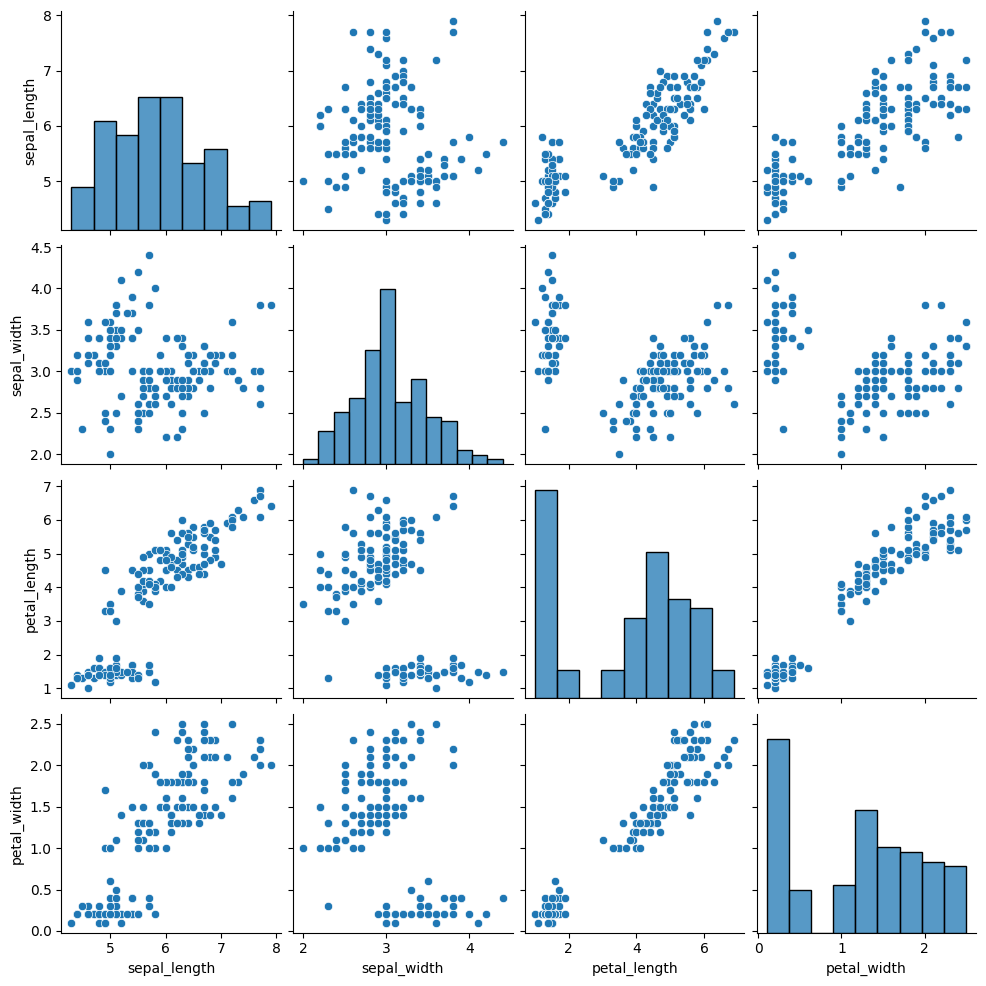

In [3]:
sns.pairplot(iris)

plt.show()

On a toujours 3 espèces que l'on représentera en 3 clouleurs différentes. Les 50 premières sont de l'espèce *setosa*, les 50 suivantes de l'espèce *versicolor* et les 50 dernière de l'espèce *virginica*

**Attention** : ces 3 espèces sont des *meta* données : ce sont les botanistes qui ont répartis les iris en espèces, ce n'est pas inhérent aux données.

## Méthode 1 : les 2 premiers axes de l'ACP

On y reviendra, mais lACP est une méthode qui permet de conserver l'inertie du nuage de points.

Prendre les 2 premiers axes correspond à maximiser la projection des points.

### ACP de données non centrée/réduite

In [4]:
from sklearn.decomposition import PCA 
import numpy as np
import pandas

In [5]:
X = iris

pca = PCA()
pca.fit(X)

U = np.transpose(pca.components_) # vecteurs propres
I = pandas.DataFrame(np.transpose(pca.explained_variance_ratio_), columns=["pourcentage"])  # information véhiculée

C = pandas.DataFrame(X @ U, index=X.index) # nouvelles coordonnées

Pourcentage d'inertie (l'_information_) conservée :

In [6]:
I

,pourcentage
0,0.924619
1,0.053066
2,0.017103
3,0.005212


### On projette nos données sur les 2 premiers axes

In [7]:
data = C.iloc[:, [0, 1]]

data

,0,1
0,2.818240,5.646350
1,2.788223,5.149951
2,2.613375,5.182003
3,2.757022,5.008654
4,2.773649,5.653707
...,...,...
145,7.446475,5.514485
146,7.029532,4.951636
147,7.266711,5.405811
148,7.403307,5.443581


In [8]:
data.dtypes

0    float64
1    float64
dtype: object

### On représente graphiquement le résultat

**bug** : avec la version actuelle de seaborn, les noms de colonnes doivent être des `str` (sinon la designation d'une colonne comme axe (dans le sns.scatterplot ne fonctionne pas).

On renomme donc les colonnes par des `str`.

In [9]:
data.columns.values

array([0, 1])

In [10]:
data.columns = (str(x) for x in data.columns)

In [11]:
data.columns.values

array(['0', '1'], dtype=object)

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()

current_palette = sns.color_palette()

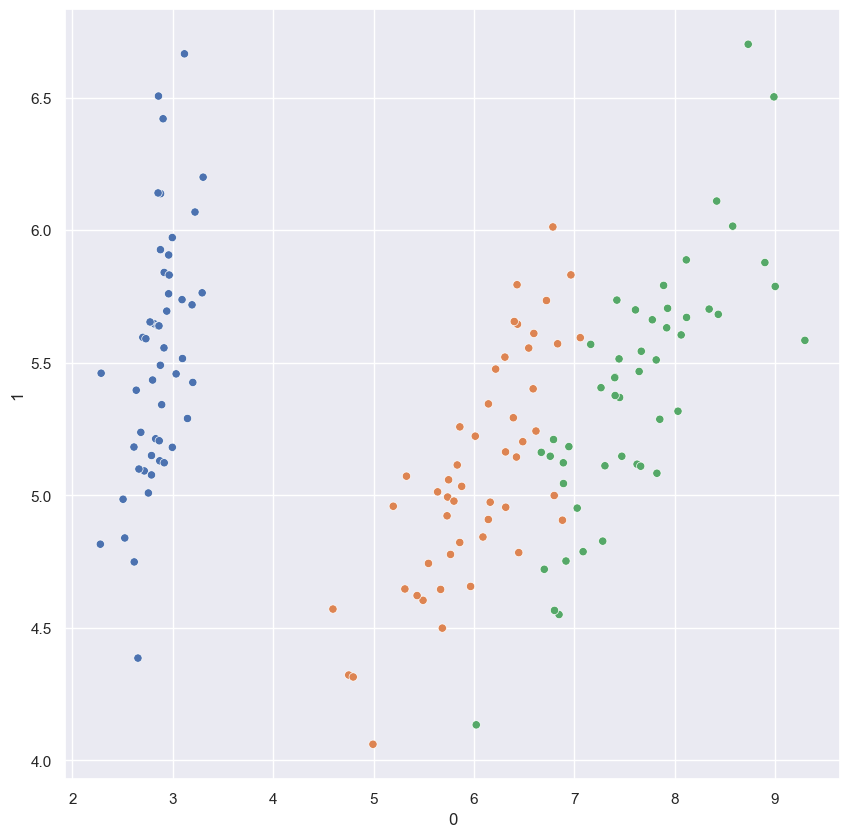

In [13]:
fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x='0', 
                y='1', 
                data=data,
                legend=False,
                hue = [0] * 50 + [1] * 50 + [2] * 50,
                palette=current_palette[:3],
                ax=ax)


plt.show()

## Méthode 2 : le hasard

Cela peut sembler idiot, mais sur des données de grandes dimensions c'est (prouvé) assez efficace.

On utilise un module de sklearn https://scikit-learn.org/stable/modules/random_projection.html

### On choisi ici 2 nouveaux axes aléatoires

In [18]:
from sklearn import random_projection

rp = random_projection.SparseRandomProjection(n_components=2, random_state=42)

### On projette nos données dessus

In [19]:
iris_random = rp.fit_transform(iris)


iris_random = pandas.DataFrame(iris_random)

iris_random

,0,1
0,-3.7,5.1
1,-3.2,4.6
2,-3.4,4.7
3,-3.3,4.8
4,-3.8,5.2
...,...,...
145,-5.3,10.5
146,-4.4,9.4
147,-5.0,10.2
148,-5.7,11.1


### On représente graphiquement le résultat

In [20]:
data = iris_random

data.columns = (str(x) for x in data.columns) # pour ce fichu bug

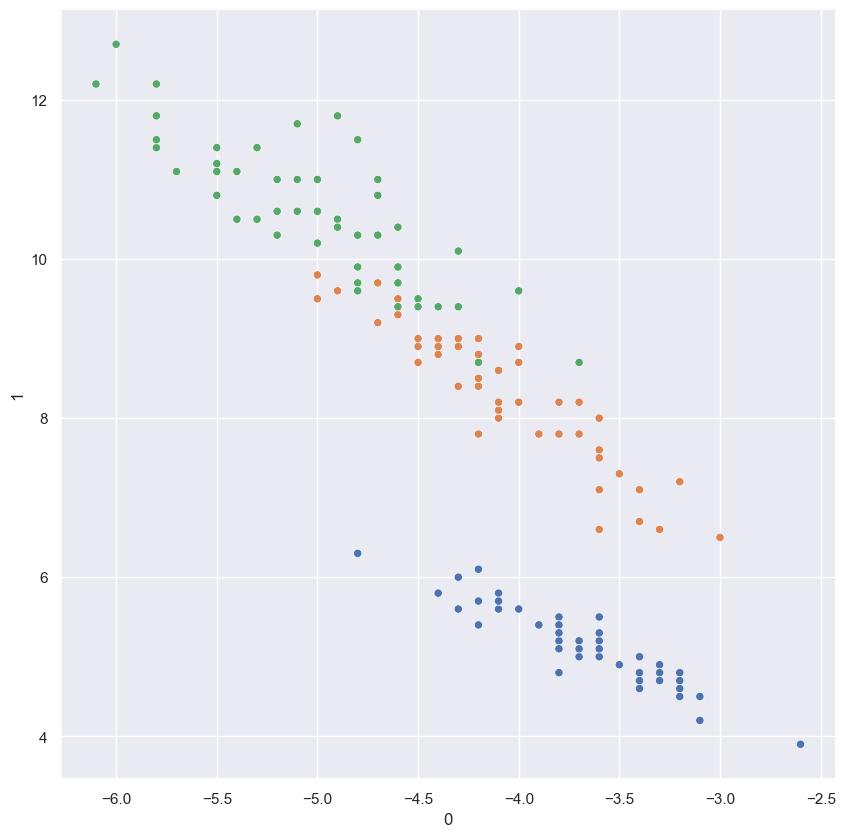

In [21]:
data = iris_random

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x="0", 
                y="1", 
                data=data,
                legend=False,
                hue = [0] * 50 + [1] * 50 + [2] * 50,
                palette=current_palette[:3],
                ax=ax)
plt.show()

## Méthode 3 : le MDS classique

Nos données sont ici décrites par une distance (pas forcément euclidienne) et on veut trouver $k$ axes telle que cette distance corresponde à la distance euclienne de points sur ces $k$ axes. 

voir : https://fr.wikipedia.org/wiki/Positionnement_multidimensionnel


Ici nos iris sont décritent dans un espace à 4 dimensions. 

On va commencer par déterminer une distance entre nos iris. Nous allons utiliser la distance euclidienne mais il y en a plein d'autres de possible : 

https://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

voir aussi https://towardsdatascience.com/3-basic-distance-measurement-in-text-mining-5852becff1d7 pour les 3 distances les plus utilisées (la dernière va vous surprendre)


### Distance euclidienne entre nos données

In [22]:
from sklearn.metrics import euclidean_distances

d = euclidean_distances(iris)

d

array([[0.        , 0.53851648, 0.50990195, ..., 4.45982062, 4.65080638,
        4.14004831],
       [0.53851648, 0.        , 0.3       , ..., 4.49888875, 4.71805044,
        4.15331193],
       [0.50990195, 0.3       , 0.        , ..., 4.66154481, 4.84871117,
        4.29883705],
       ...,
       [4.45982062, 4.49888875, 4.66154481, ..., 0.        , 0.6164414 ,
        0.64031242],
       [4.65080638, 4.71805044, 4.84871117, ..., 0.6164414 , 0.        ,
        0.76811457],
       [4.14004831, 4.15331193, 4.29883705, ..., 0.64031242, 0.76811457,
        0.        ]])

In [ ]:
# c'est une liste de liste. Par exemple distance entre l'élément 0 et l'élément 42
d[0][42]

In [ ]:
# ou au format numpy

d[0, 42]

On cherche ensuite 2 dimensions pour les quelles cette distance serait bien conservée

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.MDS.html#sklearn.manifold.MDS

### On trouve 2 axes permettant de recréer la distance de façon approchée

In [24]:
from sklearn import manifold

In [25]:
mds = manifold.MDS(n_components=2, max_iter=3000,
                   dissimilarity="precomputed", n_jobs=1)

pos = mds.fit(d).embedding_
pos

array([[ 0.10599416,  2.71539329],
       [-0.4096682 ,  2.70250427],
       [-0.35184404,  2.88765884],
       [-0.53207585,  2.72328836],
       [ 0.12654064,  2.76688165],
       [ 0.5768779 ,  2.34619504],
       [-0.2885838 ,  2.84529168],
       [-0.04072972,  2.64222506],
       [-0.77543412,  2.85364514],
       [-0.33005838,  2.66516483],
       [ 0.45723116,  2.56142878],
       [-0.17977986,  2.61715681],
       [-0.46838889,  2.77072338],
       [-0.73068707,  3.19974238],
       [ 0.99664769,  2.74849294],
       [-1.15567707,  2.46235396],
       [ 0.62376546,  2.70137103],
       [ 0.10888052,  2.67991189],
       [ 0.71435082,  2.27320063],
       [ 0.33387992,  2.64514952],
       [ 0.22590711,  2.33497653],
       [ 0.25749018,  2.58804809],
       [-0.09581577,  3.25727907],
       [-0.07055107,  2.306195  ],
       [-0.26534085,  2.33842921],
       [-0.38056588,  2.48566962],
       [-0.05304745,  2.4788596 ],
       [ 0.15763146,  2.59569015],
       [ 0.0993043 ,

### On représente graphiquement le résultat

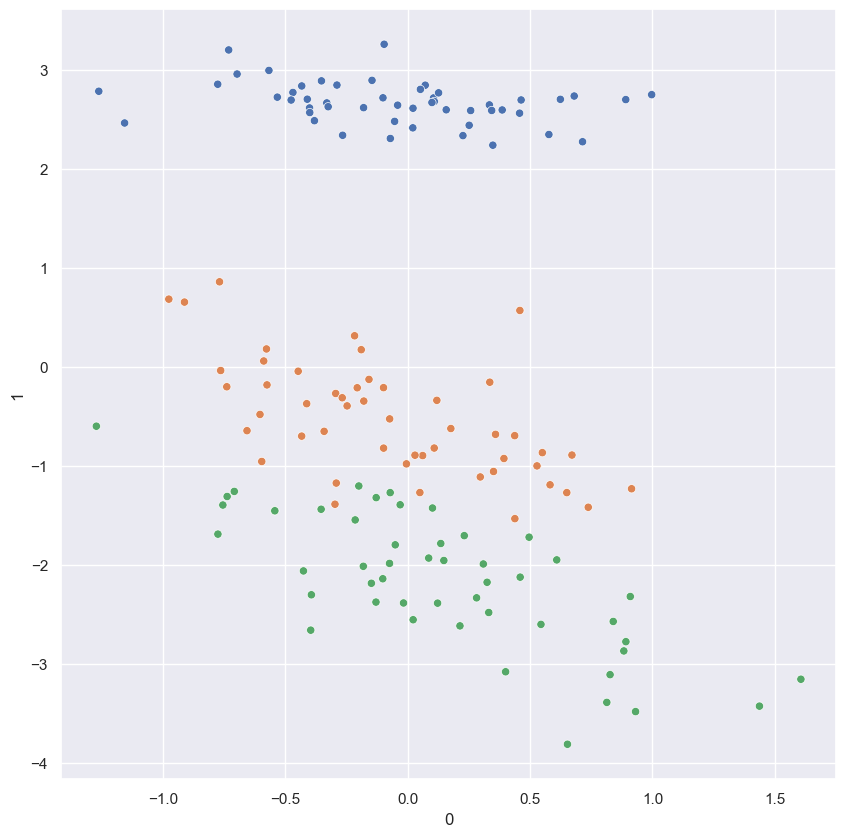

In [26]:
data = pandas.DataFrame(pos)
data.columns=(str(x) for x in data.columns) # pour ce fichu bug

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x='0', 
                y='1', 
                data=data,
                legend=False,
                hue = [0] * 50 + [1] * 50 + [2] * 50,
                palette=current_palette[:3],
                ax=ax)
plt.show()

## Méthode 4 : isomap

On essaie non pas de conserver toutes les distances mais seulement les $k$ plus proches.

https://scikit-learn.org/stable/modules/generated/sklearn.manifold.Isomap.html#sklearn.manifold.Isomap

### On trouve 2 axes permettant de recréer la distance des 10 plus proches voisins de façon approchée

In [27]:
mds = manifold.Isomap(n_neighbors=10,
                      n_components=2, max_iter=3000,                      
                      metric="precomputed")

pos = mds.fit(d).embedding_
pos

/opt/homebrew/lib/python3.13/site-packages/sklearn/manifold/_isomap.py:359: UserWarning: The number of connected components of the neighbors graph is 2 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.
  self._fit_transform(X)
/opt/homebrew/lib/python3.13/site-packages/scipy/sparse/_index.py:108: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil and dok are more efficient.
  self._set_intXint(row, col, x.flat[0])


array([[-3.14010717e+00, -1.11793172e-01],
       [-3.36155330e+00, -1.67863415e-01],
       [-3.57830241e+00, -1.92770398e-01],
       [-3.47595477e+00, -1.83556912e-01],
       [-3.20891914e+00, -1.07435753e-01],
       [-3.49909978e+00,  3.00508983e-02],
       [-3.39195081e+00, -1.64331750e-01],
       [-3.02220551e+00, -1.33459832e-01],
       [-3.74904607e+00, -2.05769751e-01],
       [-3.31351085e+00, -1.63247897e-01],
       [-3.31058912e+00, -3.29959992e-02],
       [-3.10666629e+00, -1.46371260e-01],
       [-3.47589130e+00, -1.81395718e-01],
       [-3.95973455e+00, -2.32085269e-01],
       [-3.84003643e+00,  8.80766176e-02],
       [-4.01557046e+00,  1.24084536e-01],
       [-3.52098205e+00,  2.88759475e-02],
       [-3.04392930e+00, -1.11159090e-01],
       [-3.49275351e+00,  7.95629798e-02],
       [-3.28224340e+00, -5.52541538e-02],
       [-3.04192472e+00, -4.04429112e-02],
       [-3.14669898e+00, -6.46365944e-02],
       [-3.67098974e+00, -1.57799221e-01],
       [-2.

### On représente graphiquement le résultat


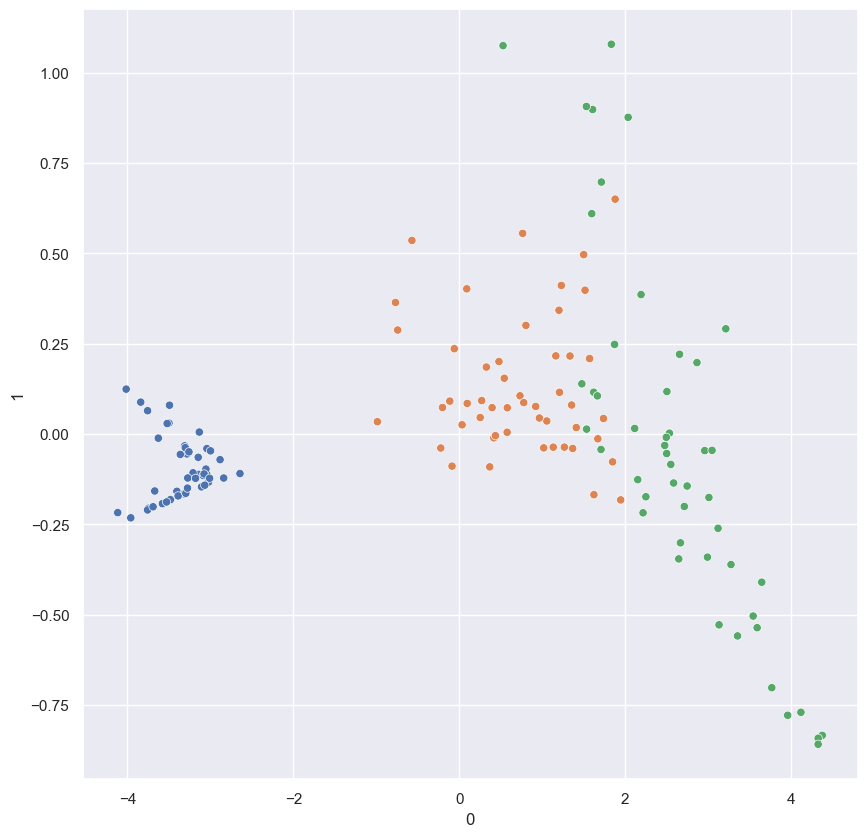

In [28]:
data = pandas.DataFrame(pos)
data.columns = (str(x) for x in data.columns) # pour ce fichu bug

fig, ax = plt.subplots(figsize=(10, 10))

sns.scatterplot(x='0', 
                y='1', 
                data=data,
                legend=False,
                hue = [0] * 50 + [1] * 50 + [2] * 50,
                palette=current_palette[:3],
                ax=ax)
plt.show()